In [1]:
import pandas as pd
import networkx as nx
from datetime import datetime, timedelta
import geopandas as gpd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Utils

In [2]:
def getTrainMaxSpeed(train_id):
    train_id = str(train_id)
    if train_id[0].isdigit():
        return "80"
    elif train_id[0].isalpha():
        if train_id[0] == "G" or train_id[0] == "C":
            return "350"
        elif train_id[0] == "D":
            return "260"
        elif train_id[0] == "Z" or train_id[0] == "T":
            return "160"
        else:
            return "120"

In [3]:
def convertTimetoMinute(time, day):
    try:
        time_float = float(time)
        # Convert the fraction of a day to a timedelta object
        delta = timedelta(days=time_float)
        start_of_day = datetime(year=1, month=1, day=1)
        time = start_of_day + delta
    except:
        pass

    if day == "Day 1":
        minutes = time.hour * 60 + time.minute
    elif day == "Day 2":
        minutes = time.hour * 60 + time.minute + 24 * 60
    elif day == "Day 3":
        minutes = time.hour * 60 + time.minute + 24 * 60 * 2
    elif day == "Day 4":
        minutes = time.hour * 60 + time.minute + 24 * 60 * 3

    return minutes

# Network Construction

## Mutli Directed Network

In [4]:
df = pd.read_excel('../data/Railway Data_JL.xlsx')
df

,train,st_no,st_id,date,arr_time,dep_time,stay_time,mileage,lat,lon
0,1095,1,692,Day 1,19:06:00,19:06:00,-,0,37.860480,112.586820
1,1095,2,1351,Day 1,19:27:00,19:32:00,5,27,37.697190,112.731180
2,1095,3,698,Day 1,19:59:00,20:01:00,2,63,37.421360,112.570320
3,1095,4,944,Day 1,20:31:00,20:35:00,4,108,37.206610,112.168470
4,1095,5,232,Day 1,21:00:00,21:04:00,4,139,37.018470,111.919060
...,...,...,...,...,...,...,...,...,...,...
69633,Z97,1,390,Day 1,13:00:00,13:00:00,-,0,39.896042,116.321152
69634,Z97,2,2175,Day 1,18:41:00,18:47:00,6,707,34.746610,113.659410
69635,Z97,3,1374,Day 1,23:16:00,23:22:00,6,1243,30.528640,114.317010
69636,Z97,4,2265,Day 2,02:35:00,02:41:00,6,1605,28.200063,113.019529


In [5]:
time_obj = datetime.strptime('0:53:18', '%H:%M:%S')
convertTimetoMinute(time_obj, "Day 1")

53

### Without outliers time datas (ex: 0.8884 and not 0:53:18)

In [6]:
G = nx.MultiDiGraph()
G

In [7]:
st_no_comp = 0
prev_node = 0
prev_mileage = 0
prev_dep_time = 0
for index, row in df.iterrows():
    if not G.has_node(row["st_id"]):
        G.add_node(row["st_id"], pos=(row["lon"], row["lat"]))
    if row["st_no"] == st_no_comp:
        G.add_edge(prev_node, row["st_id"], arr_time=convertTimetoMinute(row["arr_time"], row["date"]), dep_time=prev_dep_time, train=row["train"], train_max_speed=getTrainMaxSpeed(row["train"]), day=row["date"])
        st_no_comp = row["st_no"] + 1
        prev_node = row["st_id"]
        prev_mileage = row["mileage"]
        prev_dep_time = convertTimetoMinute(row["dep_time"], row["date"])
    else:
        prev_dep_time = convertTimetoMinute(row["dep_time"], row["date"])
        st_no_comp = row["st_no"] + 1
        prev_node = row["st_id"]
        prev_mileage = row["mileage"]


In [8]:
G.number_of_nodes()

2719

In [9]:
G.number_of_edges()

64155

In [ ]:
for node in list(G.nodes):
    print(node, G.out_edges(node))

In [ ]:
for edge in list(G.edges):
    print(edge,G[edge[0]][edge[1]][edge[2]]["day"], G[edge[0]][edge[1]][edge[2]]["dep_time"], G[edge[0]][edge[1]][edge[2]]["arr_time"], G[edge[0]][edge[1]][edge[2]]["train"], G[edge[0]][edge[1]][edge[2]]["train_max_speed"])

## Simplified Single Directed network

In [12]:
SG = G

for edge in list(SG.edges):
    if edge[2] != 0:
        SG.remove_edge(edge[0], edge[1], key=edge[2])

In [13]:
SG.number_of_nodes()

2719

In [14]:
SG.number_of_edges()

10789

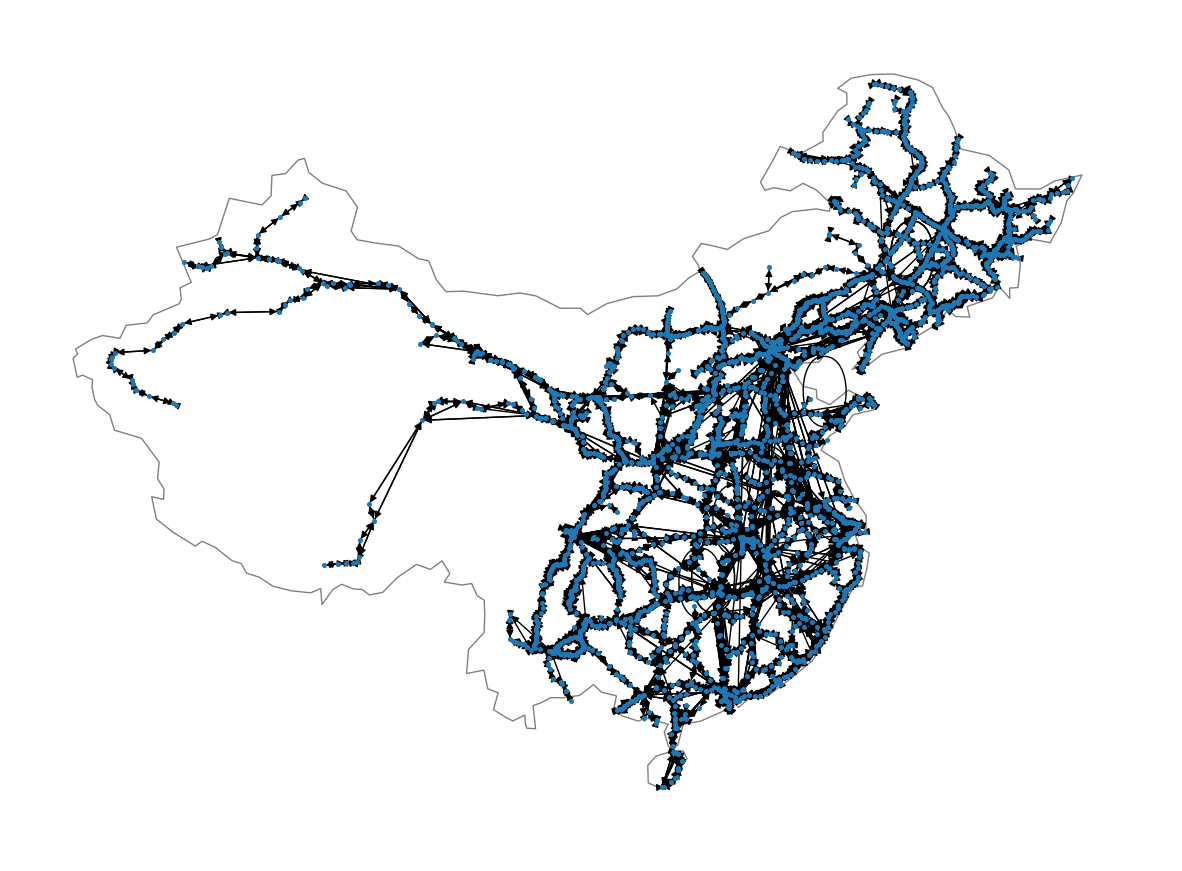

In [15]:
pos = nx.get_node_attributes(SG, 'pos')
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
china = world[world["name"] == "China"]
china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(15,15))
nx.draw(SG,pos,node_size=7, width=1 )

## Undirected network only spatial

In [16]:
SG = SG.to_undirected(reciprocal=False)

In [17]:
SG.number_of_nodes()

2719

In [18]:
SG.number_of_edges()

6173

In [ ]:
for edge,data in list(SG.nodes(data=True)):
    print(edge, data)

In [20]:
pos = nx.get_node_attributes(SG, 'pos')

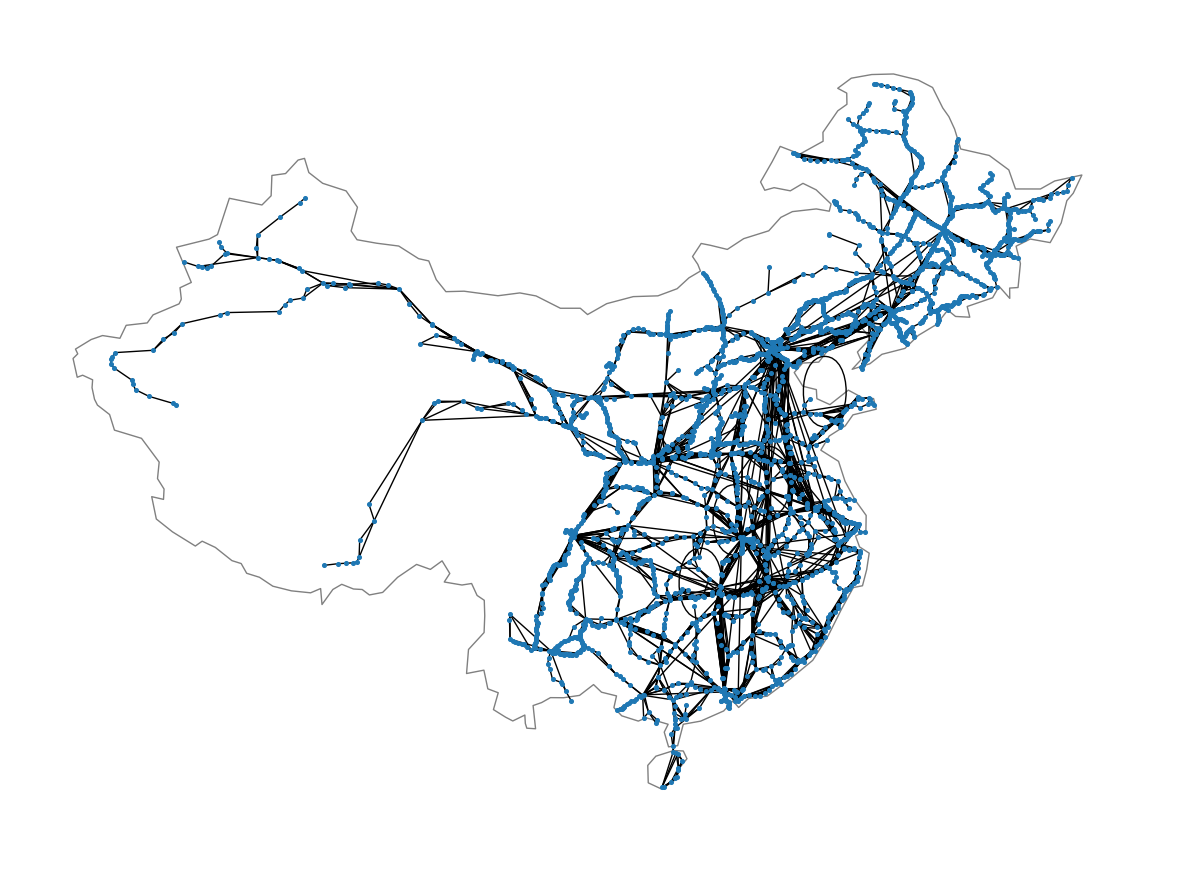

In [21]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
china = world[world["name"] == "China"]
china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(15,15))
nx.draw(SG,pos,node_size=7, width=1 )

## Animated graph

In [22]:
# Import slider package
from matplotlib.widgets import Slider

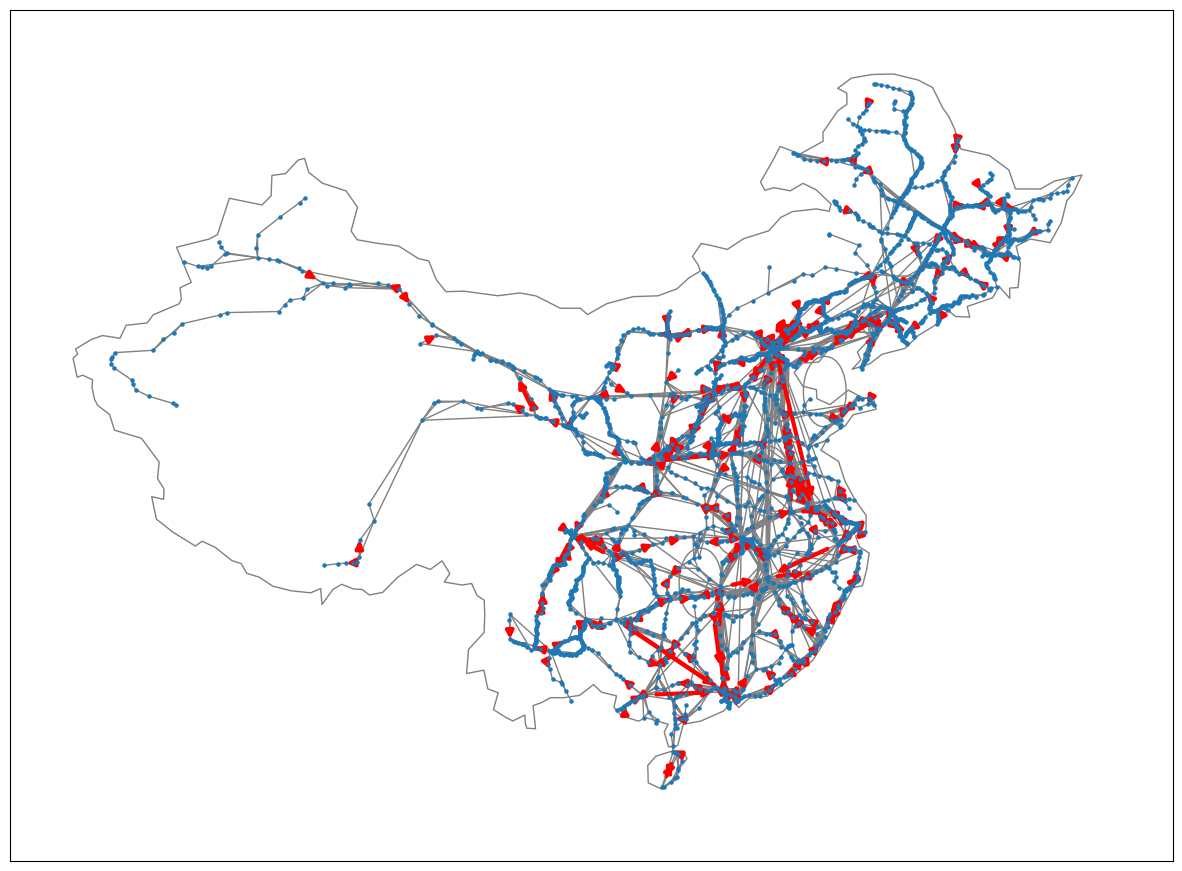

In [23]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
china = world[world["name"] == "China"]
china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(15,15))
nx.draw_networkx_nodes(SG,pos,node_size=5)
nx.draw_networkx_edges(SG,pos, width=1, edge_color="grey")
G2 = nx.DiGraph(((source, target, attr) for source, target, attr in G.edges(data=True) if attr['dep_time'] < 600 and attr['arr_time'] > 600))
nx.draw_networkx_edges(G2,pos, width=3, edge_color="red")

In [24]:
G2 = nx.DiGraph(((source, target, attr) for source, target, attr in G.edges(data=True) if attr['dep_time'] < 600 and attr['arr_time'] > 600))

In [25]:
G2.number_of_nodes()

446

In [26]:
G2.number_of_edges()

292

In [29]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig, ax = plt.subplots()

min_slider = min(list(nx.get_edge_attributes(G, 'dep_time').values()))
max_slider = max(list(nx.get_edge_attributes(G, 'arr_time').values()))

int_range = widgets.IntSlider(min=min_slider, max=max_slider, step=10, value=((max_slider-min_slider)/2))
output2 = widgets.Output()

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
china = world[world["name"] == "China"]

display(int_range, output2)

def on_value_change(change):
    with output2:
        ax.clear()
        G2 = nx.DiGraph(((source, target, attr) for source, target, attr in G.edges(data=True) if attr['dep_time'] < change['new'] and attr['arr_time'] > change['new']))
        china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(20,20),ax=ax, legend=True)
        nx.draw_networkx_nodes(SG,pos,node_size=1, ax=ax)
        nx.draw_networkx_edges(G2,pos, width=1, edge_color="red",ax=ax)
        plt.show()

int_range.observe(on_value_change, names='value')